In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-10 18:02:22.221949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 18:02:22.406027: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-10 18:02:25.580661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 18:02:25.580839: W tensorflow/strea

2.10.1


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-10 18:02:30.298712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 18:02:30.298761: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-10 18:02:30.298790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bdc78def8d2f): /proc/driver/nvidia/version does not exist
2023-09-10 18:02:30.299040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 100

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-03', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 3.9613 - accuracy: 0.1134
Epoch 1: accuracy improved from -inf to 0.11335, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 105s 2s/step - loss: 3.9613 - accuracy: 0.1134 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 3.8850 - accuracy: 0.1266
Epoch 2: accuracy improved from 0.11335 to 0.12656, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 3.8850 - accuracy: 0.1266 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 3.8512 - accuracy: 0.1551
Epoch 3: accuracy improved from 0.12656 to 0.15508, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 103s 2s/step - loss: 3.8512 - accuracy: 0.1551 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 3.8161 - accuracy: 0.1579
Epoch 4: accuracy improved from 0.15508 to 0.15786, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 3.8161 - accuracy: 0.1579 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 3.7702 - accuracy: 0.1885
Epoch 5: accuracy improved from 0.15786 to 0.18846, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 3.7702 - accuracy: 0.1885 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 3.6857 - accuracy: 0.2330
Epoch 6: accuracy improved from 0.18846 to 0.23296, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 101s 2s/step - loss: 3.6857 - accuracy: 0.2330 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 3.5890 - accuracy: 0.2796
Epoch 7: accuracy improved from 0.23296 to 0.27955, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 103s 2s/step - loss: 3.5890 - accuracy: 0.2796 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 3.5494 - accuracy: 0.2865
Epoch 8: accuracy improved from 0.27955 to 0.28651, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 101s 2s/step - loss: 3.5494 - accuracy: 0.2865 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 3.4593 - accuracy: 0.3060
Epoch 9: accuracy improved from 0.28651 to 0.30598, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 101s 2s/step - loss: 3.4593 - accuracy: 0.3060 - lr: 0.0010
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 3.3775 - accuracy: 0.3519
Epoch 10: accuracy improved from 0.30598 to 0.35188, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 3.3775 - accuracy: 0.3519 - lr: 0.0010
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 3.3020 - accuracy: 0.3609
Epoch 11: accuracy improved from 0.35188 to 0.36092, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 3.3020 - accuracy: 0.3609 - lr: 0.0010
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 3.2020 - accuracy: 0.4033
Epoch 12: accuracy improved from 0.36092 to 0.40334, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 101s 2s/step - loss: 3.2020 - accuracy: 0.4033 - lr: 0.0010
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 3.1545 - accuracy: 0.4312
Epoch 13: accuracy improved from 0.40334 to 0.43115, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 101s 2s/step - loss: 3.1545 - accuracy: 0.4312 - lr: 0.0010
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 3.0644 - accuracy: 0.4576
Epoch 14: accuracy improved from 0.43115 to 0.45758, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 3.0644 - accuracy: 0.4576 - lr: 0.0010
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 2.9635 - accuracy: 0.5000
Epoch 15: accuracy improved from 0.45758 to 0.50000, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.9635 - accuracy: 0.5000 - lr: 0.0010
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 2.9178 - accuracy: 0.5250
Epoch 16: accuracy improved from 0.50000 to 0.52503, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 98s 2s/step - loss: 2.9178 - accuracy: 0.5250 - lr: 0.0010
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 2.8617 - accuracy: 0.5522
Epoch 17: accuracy improved from 0.52503 to 0.55216, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 2.8617 - accuracy: 0.5522 - lr: 0.0010
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 2.7837 - accuracy: 0.5647
Epoch 18: accuracy improved from 0.55216 to 0.56467, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 2.7837 - accuracy: 0.5647 - lr: 0.0010
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 2.6522 - accuracy: 0.6175
Epoch 19: accuracy improved from 0.56467 to 0.61752, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.6522 - accuracy: 0.6175 - lr: 0.0010
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 2.6338 - accuracy: 0.6134
Epoch 20: accuracy did not improve from 0.61752
45/45 [==============================] - 97s 2s/step - loss: 2.6338 - accuracy: 0.6134 - lr: 0.0010
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 2.5202 - accuracy: 0.6579
Epoch 21: accuracy improved from 0.61752 to 0.65786, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.5202 - accuracy: 0.6579 - lr: 0.0010
Epoch 22/100
45/45 [==============================] - ETA: 0s - loss: 2.5123 - accuracy: 0.6634
Epoch 22: accuracy improved from 0.65786 to 0.66342, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 2.5123 - accuracy: 0.6634 - lr: 0.0010
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 2.4537 - accuracy: 0.6905
Epoch 23: accuracy improved from 0.66342 to 0.69054, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.4537 - accuracy: 0.6905 - lr: 0.0010
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 2.3830 - accuracy: 0.7211
Epoch 24: accuracy improved from 0.69054 to 0.72114, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 98s 2s/step - loss: 2.3830 - accuracy: 0.7211 - lr: 0.0010
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 2.3834 - accuracy: 0.7107
Epoch 25: accuracy did not improve from 0.72114
45/45 [==============================] - 95s 2s/step - loss: 2.3834 - accuracy: 0.7107 - lr: 0.0010
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 2.2798 - accuracy: 0.7601
Epoch 26: accuracy improved from 0.72114 to 0.76008, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.2798 - accuracy: 0.7601 - lr: 0.0010
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 2.2310 - accuracy: 0.7601
Epoch 27: accuracy did not improve from 0.76008
45/45 [==============================] - 95s 2s/step - loss: 2.2310 - accuracy: 0.7601 - lr: 0.0010
Epoch 28/100
45/45 [==============================] - ETA: 0s - loss: 2.2322 - accuracy: 0.7705
Epoch 28: accuracy improved from 0.76008 to 0.77051, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.2322 - accuracy: 0.7705 - lr: 0.0010
Epoch 29/100
45/45 [==============================] - ETA: 0s - loss: 2.1709 - accuracy: 0.7830
Epoch 29: accuracy improved from 0.77051 to 0.78303, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 2.1709 - accuracy: 0.7830 - lr: 0.0010
Epoch 30/100
45/45 [==============================] - ETA: 0s - loss: 2.1482 - accuracy: 0.8053
Epoch 30: accuracy improved from 0.78303 to 0.80529, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 2.1482 - accuracy: 0.8053 - lr: 0.0010
Epoch 31/100
45/45 [==============================] - ETA: 0s - loss: 2.0844 - accuracy: 0.8150
Epoch 31: accuracy improved from 0.80529 to 0.81502, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 2.0844 - accuracy: 0.8150 - lr: 0.0010
Epoch 32/100
45/45 [==============================] - ETA: 0s - loss: 2.0341 - accuracy: 0.8255
Epoch 32: accuracy improved from 0.81502 to 0.82545, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 2.0341 - accuracy: 0.8255 - lr: 0.0010
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 2.0147 - accuracy: 0.8268
Epoch 33: accuracy improved from 0.82545 to 0.82684, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 101s 2s/step - loss: 2.0147 - accuracy: 0.8268 - lr: 0.0010
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 1.9761 - accuracy: 0.8512
Epoch 34: accuracy improved from 0.82684 to 0.85118, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 1.9761 - accuracy: 0.8512 - lr: 0.0010
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 1.9863 - accuracy: 0.8366
Epoch 35: accuracy did not improve from 0.85118
45/45 [==============================] - 96s 2s/step - loss: 1.9863 - accuracy: 0.8366 - lr: 0.0010
Epoch 36/100
45/45 [==============================] - ETA: 0s - loss: 1.9827 - accuracy: 0.8463
Epoch 36: accuracy did not improve from 0.85118
45/45 [==============================] - 95s 2s/step - loss: 1.9827 - accuracy: 0.8463 - lr: 0.0010
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 1.9822 - accuracy: 0.8463
Epoch 37: accuracy did not improve from 0.85118
45/45 [==============================] - 96s 2s/step - loss: 1.9822 - accuracy: 0.8463 - lr: 0.0010
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 1.8845 - accuracy: 0.8720
Epoch 38: accuracy improved from 0.85118 to 0.87204, saving model to mo

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 1.8845 - accuracy: 0.8720 - lr: 2.0000e-04
Epoch 39/100
45/45 [==============================] - ETA: 0s - loss: 1.8812 - accuracy: 0.8720
Epoch 39: accuracy did not improve from 0.87204
45/45 [==============================] - 95s 2s/step - loss: 1.8812 - accuracy: 0.8720 - lr: 2.0000e-04
Epoch 40/100
45/45 [==============================] - ETA: 0s - loss: 1.8281 - accuracy: 0.8929
Epoch 40: accuracy improved from 0.87204 to 0.89291, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 1.8281 - accuracy: 0.8929 - lr: 2.0000e-04
Epoch 41/100
45/45 [==============================] - ETA: 0s - loss: 1.8414 - accuracy: 0.8901
Epoch 41: accuracy did not improve from 0.89291
45/45 [==============================] - 95s 2s/step - loss: 1.8414 - accuracy: 0.8901 - lr: 2.0000e-04
Epoch 42/100
45/45 [==============================] - ETA: 0s - loss: 1.8267 - accuracy: 0.8846
Epoch 42: accuracy did not improve from 0.89291
45/45 [==============================] - 96s 2s/step - loss: 1.8267 - accuracy: 0.8846 - lr: 2.0000e-04
Epoch 43/100
45/45 [==============================] - ETA: 0s - loss: 1.8222 - accuracy: 0.8915
Epoch 43: accuracy did not improve from 0.89291
45/45 [==============================] - 95s 2s/step - loss: 1.8222 - accuracy: 0.8915 - lr: 2.0000e-04
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 1.8169 - accuracy: 0.8936
Epoch 44: accuracy improved from 0.89291 to 0.89360, sav

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 102s 2s/step - loss: 1.8169 - accuracy: 0.8936 - lr: 2.0000e-04
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 1.8178 - accuracy: 0.8873
Epoch 45: accuracy did not improve from 0.89360
45/45 [==============================] - 100s 2s/step - loss: 1.8178 - accuracy: 0.8873 - lr: 2.0000e-04
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 1.8252 - accuracy: 0.8866
Epoch 46: accuracy did not improve from 0.89360
45/45 [==============================] - 100s 2s/step - loss: 1.8252 - accuracy: 0.8866 - lr: 2.0000e-04
Epoch 47/100
45/45 [==============================] - ETA: 0s - loss: 1.8490 - accuracy: 0.8894
Epoch 47: accuracy did not improve from 0.89360
45/45 [==============================] - 100s 2s/step - loss: 1.8490 - accuracy: 0.8894 - lr: 2.0000e-04
Epoch 48/100
45/45 [==============================] - ETA: 0s - loss: 1.8068 - accuracy: 0.8964
Epoch 48: accuracy improved from 0.89360 to 0.89638,

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 1.8068 - accuracy: 0.8964 - lr: 4.0000e-05
Epoch 49/100
45/45 [==============================] - ETA: 0s - loss: 1.8285 - accuracy: 0.8950
Epoch 49: accuracy did not improve from 0.89638
45/45 [==============================] - 96s 2s/step - loss: 1.8285 - accuracy: 0.8950 - lr: 4.0000e-05
Epoch 50/100
45/45 [==============================] - ETA: 0s - loss: 1.8186 - accuracy: 0.8908
Epoch 50: accuracy did not improve from 0.89638
45/45 [==============================] - 96s 2s/step - loss: 1.8186 - accuracy: 0.8908 - lr: 4.0000e-05
Epoch 51/100
43/45 [===========================>..] - ETA: 4s - loss: 1.7790 - accuracy: 0.9105

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 100s 2s/step - loss: 1.7812 - accuracy: 0.9075 - lr: 4.0000e-05
Epoch 52/100
45/45 [==============================] - ETA: 0s - loss: 1.8261 - accuracy: 0.8887
Epoch 52: accuracy did not improve from 0.90751
45/45 [==============================] - 96s 2s/step - loss: 1.8261 - accuracy: 0.8887 - lr: 4.0000e-05
Epoch 53/100
45/45 [==============================] - ETA: 0s - loss: 1.7773 - accuracy: 0.9019
Epoch 53: accuracy did not improve from 0.90751
45/45 [==============================] - 96s 2s/step - loss: 1.7773 - accuracy: 0.9019 - lr: 4.0000e-05
Epoch 54/100
45/45 [==============================] - ETA: 0s - loss: 1.8140 - accuracy: 0.8873
Epoch 54: accuracy did not improve from 0.90751
45/45 [==============================] - 95s 2s/step - loss: 1.8140 - accuracy: 0.8873 - lr: 4.0000e-05
Epoch 55/100
45/45 [==============================] - ETA: 0s - loss: 1.7978 - accuracy: 0.9026
Epoch 55: accuracy did not improve from 0.90751
45/45 [

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 97s 2s/step - loss: 1.7713 - accuracy: 0.9096 - lr: 1.0000e-06
Epoch 74/100
45/45 [==============================] - ETA: 0s - loss: 1.7989 - accuracy: 0.9089
Epoch 74: accuracy did not improve from 0.90960
45/45 [==============================] - 95s 2s/step - loss: 1.7989 - accuracy: 0.9089 - lr: 1.0000e-06
Epoch 75/100
45/45 [==============================] - ETA: 0s - loss: 1.7840 - accuracy: 0.9082
Epoch 75: accuracy did not improve from 0.90960
45/45 [==============================] - 93s 2s/step - loss: 1.7840 - accuracy: 0.9082 - lr: 1.0000e-06
Epoch 76/100
45/45 [==============================] - ETA: 0s - loss: 1.7973 - accuracy: 0.8908
Epoch 76: accuracy did not improve from 0.90960
45/45 [==============================] - 94s 2s/step - loss: 1.7973 - accuracy: 0.8908 - lr: 1.0000e-06
Epoch 77/100
45/45 [==============================] - ETA: 0s - loss: 1.7800 - accuracy: 0.9096
Epoch 77: accuracy did not improve from 0.90960
45/45 [=

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 99s 2s/step - loss: 1.7816 - accuracy: 0.9117 - lr: 1.0000e-06
Epoch 83/100
45/45 [==============================] - ETA: 0s - loss: 1.8088 - accuracy: 0.8985
Epoch 83: accuracy did not improve from 0.91168
45/45 [==============================] - 100s 2s/step - loss: 1.8088 - accuracy: 0.8985 - lr: 1.0000e-06
Epoch 84/100
45/45 [==============================] - ETA: 0s - loss: 1.8181 - accuracy: 0.9006
Epoch 84: accuracy did not improve from 0.91168
45/45 [==============================] - 98s 2s/step - loss: 1.8181 - accuracy: 0.9006 - lr: 1.0000e-06
Epoch 85/100
45/45 [==============================] - ETA: 0s - loss: 1.8098 - accuracy: 0.8901
Epoch 85: accuracy did not improve from 0.91168
45/45 [==============================] - 99s 2s/step - loss: 1.8098 - accuracy: 0.8901 - lr: 1.0000e-06
Epoch 86/100
45/45 [==============================] - ETA: 0s - loss: 1.8107 - accuracy: 0.8950
Epoch 86: accuracy did not improve from 0.91168
45/45 [

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


45/45 [==============================] - 97s 2s/step - loss: 1.7421 - accuracy: 0.9228 - lr: 1.0000e-06
Epoch 97/100
45/45 [==============================] - ETA: 0s - loss: 1.7903 - accuracy: 0.9026
Epoch 97: accuracy did not improve from 0.92281
45/45 [==============================] - 93s 2s/step - loss: 1.7903 - accuracy: 0.9026 - lr: 1.0000e-06
Epoch 98/100
45/45 [==============================] - ETA: 0s - loss: 1.7945 - accuracy: 0.9033
Epoch 98: accuracy did not improve from 0.92281
45/45 [==============================] - 94s 2s/step - loss: 1.7945 - accuracy: 0.9033 - lr: 1.0000e-06
Epoch 99/100
45/45 [==============================] - ETA: 0s - loss: 1.8027 - accuracy: 0.9019
Epoch 99: accuracy did not improve from 0.92281
45/45 [==============================] - 93s 2s/step - loss: 1.8027 - accuracy: 0.9019 - lr: 1.0000e-06
Epoch 100/100
45/45 [==============================] - ETA: 0s - loss: 1.7981 - accuracy: 0.8985
Epoch 100: accuracy did not improve from 0.92281
45/45 

In [11]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 6s 580ms/step


In [12]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 6s 611ms/step - loss: 1.6449 - accuracy: 0.9594


In [13]:
evaluate_test

[1.6448701620101929, 0.9593750238418579]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       6, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 3, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 9, 7, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.946875

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  2,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0, 30,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 28,  3,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  2, 28,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 31]])

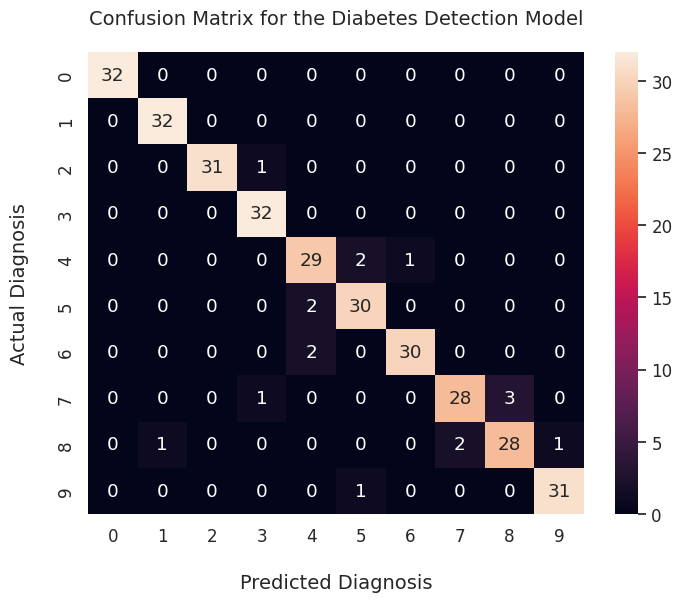

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [19]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 6s 588ms/step


In [20]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 6s 545ms/step - loss: 1.6638 - accuracy: 0.9572


In [21]:
evaluate_val

[1.663759708404541, 0.9572368264198303]

In [22]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 3,
       7, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [23]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [24]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9572368421052632

In [25]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 29,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  1, 29,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 30,  1,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0, 27,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 28,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

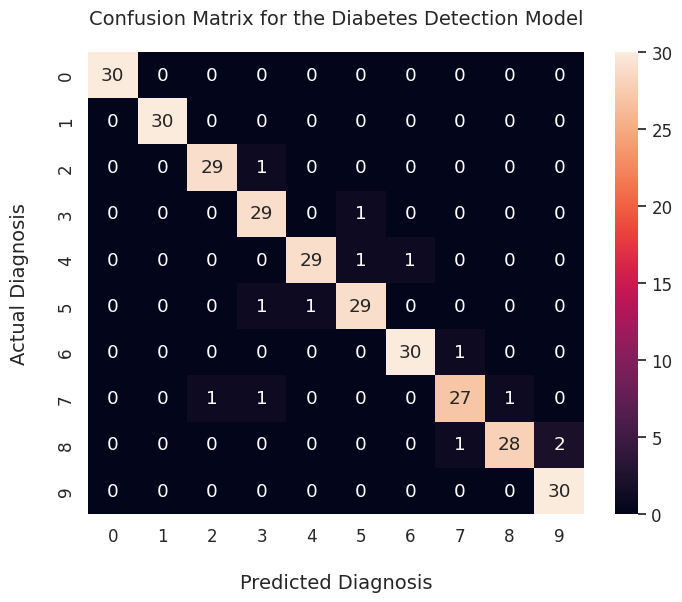

In [26]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()